In [10]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# ======================= 1. Install & Import ======================
# import torch
# print("Torch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("CUDA device count:", torch.cuda.device_count())


In [12]:
import os
import timm
import torch
import torch.nn as nn
from torchvision import transforms
# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import torch.multiprocessing as mp
# from dataset import Stanford40Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

# Class
from PIL import Image
from torch.utils.data import Dataset

# for report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [13]:
# ======================= 2. Custom Dataset ========================
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(split_file) as f:
            # danh sách tên ảnh (không .jpg)
            self.names = [l.strip().split(".")[0] for l in f if l.strip().split(".")[0]]
        # build list nhãn đầy đủ
        labels = sorted({self._label_from_name(n) for n in self.names})
        self.cls2idx = {c:i for i,c in enumerate(labels)}

    def _label_from_name(self, name):
        parts = name.split("_")
        return "_".join(parts[:-1])  # hoặc " ".join(parts[:-1])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(self.img_dir, name + ".jpg")
        img = Image.open(img_path).convert("RGB")
        label_str = self._label_from_name(name)
        label = self.cls2idx[label_str]
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
# ======================= 3. Hyperparams & Transforms ==============
NUM_CLASSES = 40
BATCH_SIZE = 32
LR = 3e-4 # Learning Rate
WD = 5e-2 # Weigth decay
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

In [15]:
# ======================= 4. DataLoader ============================
DATA_ROOT = "/kaggle/input/stanford40"
train_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "train.txt"),
    transform=train_transform)
val_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "test.txt"),
    transform=val_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [16]:
# =============== 5. Model ===============
# model = timm.create_model("convit_base", pretrained=True)

# # Freeze toàn bộ parameters trước
# for param in model.parameters():
#     param.requires_grad = False

# # Thay classifier head
# in_features = model.head.in_features
# model.head = nn.Linear(in_features, NUM_CLASSES)

# # Head mới có requires_grad=True theo mặc định
# model = model.to(DEVICE)
model = timm.create_model("convit_base", pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

In [17]:
# ======================= 6. Optimizer, Scheduler, Loss ===========
# AdamW, lr 3e-4, weight_decay 5e-2
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=LR, weight_decay= WD)
# cosine + 5-epoch warm-up
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
              optimizer, T_max=25,  # 30-5 warm epochs
              eta_min=1e-6)

criterion = nn.CrossEntropyLoss()


In [18]:
# ======================= 7. Training Loop ========================
train_losses = []
val_losses   = []
val_accs     = []

NUM_EPOCHS = 30 # try 30 epoch when freeze head

best_acc = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    # ======== Training ========
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_train_loss += loss.item() * batch_size
        num_train_samples += batch_size

    avg_train_loss = running_train_loss / num_train_samples
    train_losses.append(avg_train_loss)
    scheduler.step()

    # ======== Validation ========
    model.eval()
    running_val_loss = 0.0
    num_val_samples = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            batch_size = imgs.size(0)
            running_val_loss += loss.item() * batch_size
            num_val_samples += batch_size

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_val_loss / num_val_samples
    val_losses.append(avg_val_loss)

    acc = correct / num_val_samples
    val_accs.append(acc)

    print(
        f"Epoch {epoch}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {acc*100:.2f}%"
    )

    # ======== Save best ========
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_convit_stanford40.pth")

print(f"Best Val Acc only head: {best_acc*100:.2f}%")

Epoch 1/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.95it/s]


Epoch 1/30 | Train Loss: 2.6392 | Val Loss: 1.7337 | Val Acc: 74.37%


Epoch 2/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 2/30 | Train Loss: 1.3134 | Val Loss: 1.0884 | Val Acc: 80.62%


Epoch 3/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 3/30 | Train Loss: 0.8729 | Val Loss: 0.8564 | Val Acc: 82.05%


Epoch 4/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 4/30 | Train Loss: 0.6861 | Val Loss: 0.7491 | Val Acc: 82.70%


Epoch 5/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 5/30 | Train Loss: 0.5761 | Val Loss: 0.6848 | Val Acc: 83.37%


Epoch 6/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 6/30 | Train Loss: 0.4995 | Val Loss: 0.6436 | Val Acc: 83.64%


Epoch 7/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 7/30 | Train Loss: 0.4390 | Val Loss: 0.6166 | Val Acc: 83.98%


Epoch 8/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 8/30 | Train Loss: 0.3954 | Val Loss: 0.5940 | Val Acc: 84.18%


Epoch 9/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 9/30 | Train Loss: 0.3618 | Val Loss: 0.5785 | Val Acc: 84.24%


Epoch 10/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 10/30 | Train Loss: 0.3355 | Val Loss: 0.5666 | Val Acc: 84.42%


Epoch 11/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 11/30 | Train Loss: 0.3134 | Val Loss: 0.5571 | Val Acc: 84.51%


Epoch 12/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 12/30 | Train Loss: 0.2996 | Val Loss: 0.5494 | Val Acc: 84.54%


Epoch 13/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 13/30 | Train Loss: 0.2819 | Val Loss: 0.5439 | Val Acc: 84.49%


Epoch 14/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 14/30 | Train Loss: 0.2642 | Val Loss: 0.5389 | Val Acc: 84.69%


Epoch 15/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 15/30 | Train Loss: 0.2549 | Val Loss: 0.5346 | Val Acc: 84.65%


Epoch 16/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 16/30 | Train Loss: 0.2456 | Val Loss: 0.5324 | Val Acc: 84.60%


Epoch 17/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 17/30 | Train Loss: 0.2377 | Val Loss: 0.5296 | Val Acc: 84.67%


Epoch 18/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 18/30 | Train Loss: 0.2303 | Val Loss: 0.5275 | Val Acc: 84.80%


Epoch 19/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 19/30 | Train Loss: 0.2273 | Val Loss: 0.5259 | Val Acc: 84.76%


Epoch 20/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 20/30 | Train Loss: 0.2250 | Val Loss: 0.5250 | Val Acc: 84.85%


Epoch 21/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 21/30 | Train Loss: 0.2190 | Val Loss: 0.5243 | Val Acc: 84.83%


Epoch 22/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 22/30 | Train Loss: 0.2177 | Val Loss: 0.5237 | Val Acc: 84.85%


Epoch 23/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 23/30 | Train Loss: 0.2154 | Val Loss: 0.5234 | Val Acc: 84.85%


Epoch 24/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 24/30 | Train Loss: 0.2121 | Val Loss: 0.5233 | Val Acc: 84.83%


Epoch 25/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 25/30 | Train Loss: 0.2170 | Val Loss: 0.5232 | Val Acc: 84.85%


Epoch 26/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 26/30 | Train Loss: 0.2137 | Val Loss: 0.5232 | Val Acc: 84.85%


Epoch 27/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 27/30 | Train Loss: 0.2153 | Val Loss: 0.5231 | Val Acc: 84.85%


Epoch 28/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 28/30 | Train Loss: 0.2152 | Val Loss: 0.5229 | Val Acc: 84.83%


Epoch 29/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 29/30 | Train Loss: 0.2130 | Val Loss: 0.5224 | Val Acc: 84.85%


Epoch 30/30 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]

Epoch 30/30 | Train Loss: 0.2184 | Val Loss: 0.5220 | Val Acc: 84.83%
Best Val Acc only head: 84.85%


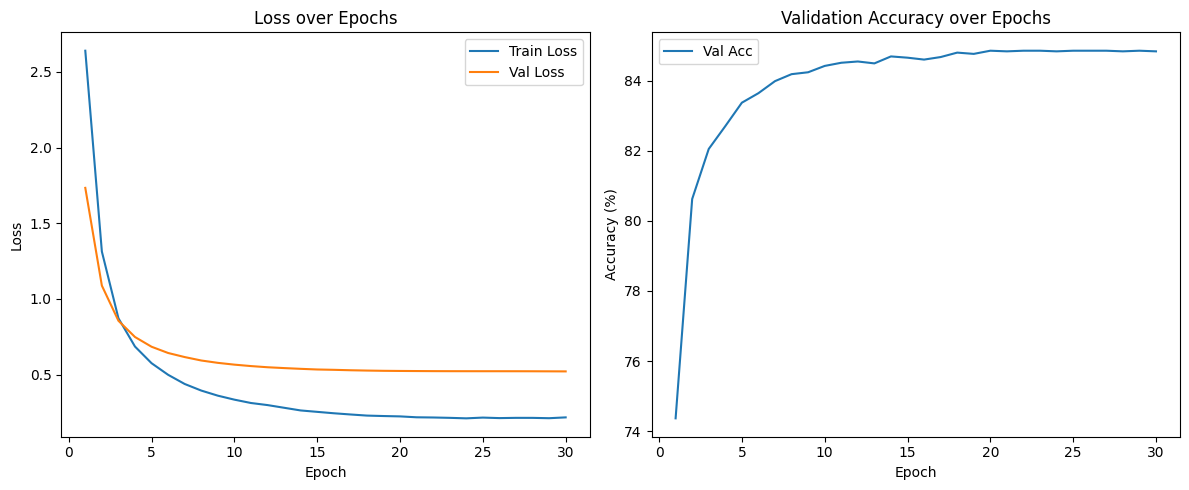

In [19]:
# ======================= 8. Loss and Accuracy ========================
epochs = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs)*100, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# ======== 9. Confusion Matrix and Classification report ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# 1) Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("=== Confusion Matrix ===")
print(cm)

# 2) Classification report
# Cần list tên các class (40 labels) theo đúng thứ tự cls2idx
classes = [c for c, idx in sorted(train_ds.cls2idx.items(), key=lambda x: x[1])]
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print("=== Classification Report ===")
print(report)

Final Eval [Val]: 100%|██████████| 173/173 [00:43<00:00,  3.98it/s]

=== Confusion Matrix ===
[[112   0   2 ...  25   3   0]
 [  1 140   2 ...   2   0   0]
 [  0   1  77 ...   2   1   0]
 ...
 [ 16   0   0 ...  70   0   0]
 [  1   0   1 ...   1  72   1]
 [  0   0   1 ...   0   1 114]]
=== Classification Report ===
                              precision    recall  f1-score   support

                  applauding     0.7273    0.6087    0.6627       184
             blowing_bubbles     0.9655    0.8805    0.9211       159
              brushing_teeth     0.7700    0.7700    0.7700       100
          cleaning_the_floor     0.9375    0.9375    0.9375       112
                    climbing     0.9577    0.9282    0.9427       195
                     cooking     0.9423    0.7819    0.8547       188
               cutting_trees     0.9327    0.9417    0.9372       103
          cutting_vegetables     0.7273    0.8090    0.7660        89
                    drinking     0.7574    0.6603    0.7055       156
             feeding_a_horse     0.9427    0.9679   

**1. Quan sát chung**
**Accuracy chung:** 84.83 % trên toàn bộ 5 532 ảnh validation.

* **Macro F1-score:** khoảng 0.8385, nghĩa là nếu lấy trung bình F1 của 40 lớp (không tính trọng số), mô hình đạt ~83.85 %.

* **Weighted F1-score:** ~0.8495, có phần cao hơn macro, vì các lớp nhiều support (ví dụ “riding_a_bike” 193 ảnh, “walking_the_dog” 193 ảnh,…) có F1 tốt hơn, kéo điểm trung bình lên.

Nhìn tổng thể, mô hình hoạt động khá tốt với nhiều lớp F1 ≥ 0.90, nhưng vẫn còn một số lớp F1 rất thấp (dưới 0.60), cần xem xét để cải thiện.

In [26]:
from sklearn.metrics import precision_recall_fscore_support

# === 9.1. TOP-5 maximum value in confusion matrix ===

# cm : numpy array (40, 40)
# create list tuple (count, true_idx, pred_idx)
flat_cm = [
    (int(cm[i, j]), i, j)
    for i in range(cm.shape[0])
    for j in range(cm.shape[1]) if (i != j)
]

# sort decs
flat_cm.sort(key=lambda x: x[0], reverse=True)

print("=== Top 20 values in Confusion Matrix ===")
for count, i, j in flat_cm[:20]:
    print(f"Count={count:4d} | True = '{classes[i]:<20}' | Pred = '{classes[j]:<20}'")
# Eg: Count= 123 | True = 'walking            ' | Pred = 'walking            '

=== Top 20 values in Confusion Matrix ===
Count=  25 | True = 'applauding          ' | Pred = 'waving_hands        '
Count=  24 | True = 'phoning             ' | Pred = 'smoking             '
Count=  23 | True = 'reading             ' | Pred = 'writing_on_a_book   '
Count=  19 | True = 'cooking             ' | Pred = 'washing_dishes      '
Count=  16 | True = 'cooking             ' | Pred = 'cutting_vegetables  '
Count=  16 | True = 'waving_hands        ' | Pred = 'applauding          '
Count=  11 | True = 'drinking            ' | Pred = 'pouring_liquid      '
Count=  11 | True = 'reading             ' | Pred = 'texting_message     '
Count=  11 | True = 'smoking             ' | Pred = 'phoning             '
Count=  10 | True = 'phoning             ' | Pred = 'taking_photos       '
Count=  10 | True = 'running             ' | Pred = 'throwing_frisby     '
Count=  10 | True = 'smoking             ' | Pred = 'texting_message     '
Count=   9 | True = 'cutting_vegetables  ' | Pred = 'washi

**2. Phân tích Top-20 giá trị lớn nhất trong Confusion Matrix**
Những cặp (true→pred) có count cao cho thấy mô hình thường nhầm lẫn giữa hai lớp đó:

* **(applauding → waving_hands) = 25 lần**

    - “applauding” (vỗ tay) và “waving_hands” (vẫy tay) đều liên quan đến hai bàn tay chuyển động, rất dễ bị nhầm.

    - Khi nhìn một người co bàn tay lên, mô hình khó phân biệt là họ đang vỗ tay hay đang vẫy chào.

* **(phoning → smoking) = 24 lần**

    - “phoning” (đang cầm điện thoại) và “smoking” (đang cầm điếu thuốc) đều có động tác đưa bàn tay lên miệng/gần miệng, bối cảnh tương tự (tay cầm vật nhỏ, ngước mắt nhìn).

    - Nếu background không rõ (ví dụ tay che mặt, màu da, ánh sáng…), model dễ nhầm.

* **(reading → writing_on_a_book) = 23 lần**

    - “reading” (đang đọc sách) và “writing_on_a_book” (đang viết vào sách) đôi khi rất giống: cả hai đều đưa đầu về phía sách, tay bám vào bìa/cuốn sách.

    - Khi ảnh không cho thấy rõ cây bút, model chỉ nhìn thấy “người gập đầu vào sách” nên không phân biệt được.

* **(cooking → washing_dishes) = 19 lần, (cooking → cutting_vegetables) = 16 lần**

    - “cooking” (nấu ăn) thường diễn ra trong bếp, xung quanh có dao thớt, nồi, cả bồn rửa bát…

    - “washing_dishes” (rửa bát) và “cutting_vegetables” (thái rau) đều là một phần của quy trình nấu ăn. Khi ảnh chỉ thấy người đứng cạnh bồn rửa, model dễ gán nhầm thành “washing_dishes” hoặc “cutting_vegetables” thay vì “cooking”.

* **(waving_hands → applauding) = 16 lần**

    - Vỗ tay và vẫy tay thường khó phân biệt chỉ qua một khung tĩnh.

* **Một số cặp nhầm lẫn khác đáng chú ý:**

    - (drinking → pouring_liquid) = 11

    - (reading → texting_message) = 11

    - (smoking → phoning) = 11, (phoning → taking_photos) = 10

    - (running → throwing_frisby) = 10: hai hoạt động này đều có cử động tay chân tương tự, đặc biệt là khi ảnh chụp lúc chạy kèm theo động tác “ném” (tay vung ra).

    - (jumping → running) = 9: đôi khi khó phân biệt tư thế nhảy với tư thế đang chạy chỉ qua một ảnh tĩnh (chân, dáng người).

* **Những cặp trên phản ánh hai vấn đề chính:**

    - Các hành động quá “lý thuyết giống nhau” về tư thế (pose) và bối cảnh (background).

    - Một số lớp thực sự nằm trong cùng tổng thể ngữ cảnh (vd “cooking” bao gồm cắt, rửa, xào, v.v.) dẫn đến nhầm lẫn.



In [30]:
# === 9.2. F1-score for all class and print top10 highest / lowest ===

# precision, recall, f1_scores, support
precision, recall, f1_scores, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(classes)),
    zero_division=0  
)

# list tuple (f1, class_idx)
f1_with_idx = [(f1_scores[i], i) for i in range(len(classes))]

# Top-10 F1 highest
f1_with_idx.sort(key=lambda x: x[0], reverse=True)
print("\n=== Top 10 highest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")



=== Top 10 highest F1-scores ===
Class = 'playing_violin      ' | F1 = 0.9814
Class = 'playing_guitar      ' | F1 = 0.9763
Class = 'shooting_an_arrow   ' | F1 = 0.9737
Class = 'riding_a_bike       ' | F1 = 0.9717
Class = 'riding_a_horse      ' | F1 = 0.9585
Class = 'feeding_a_horse     ' | F1 = 0.9551
Class = 'rowing_a_boat       ' | F1 = 0.9545
Class = 'fishing             ' | F1 = 0.9510
Class = 'walking_the_dog     ' | F1 = 0.9485
Class = 'fixing_a_car        ' | F1 = 0.9470


In [31]:
# Top-10 F1 lowest
f1_with_idx.sort(key=lambda x: x[0]) 
print("\n=== Top 10 lowest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")


=== Top 10 lowest F1-scores ===
Class = 'waving_hands        ' | F1 = 0.5645
Class = 'texting_message     ' | F1 = 0.5688
Class = 'phoning             ' | F1 = 0.5772
Class = 'pouring_liquid      ' | F1 = 0.6502
Class = 'smoking             ' | F1 = 0.6549
Class = 'taking_photos       ' | F1 = 0.6605
Class = 'applauding          ' | F1 = 0.6627
Class = 'washing_dishes      ' | F1 = 0.6769
Class = 'reading             ' | F1 = 0.7033
Class = 'drinking            ' | F1 = 0.7055


In [32]:
all_with_idx = [(precision[i], recall[i], f1_scores[i], support[i], i) for i in range(len(classes))]
all_with_idx.sort(key=lambda x: x[2]) 
for pre, rec, f1, sup, idx in all_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | precision = {pre:.4f} | recall = {rec:.4f} | F1 = {f1:.4f} | support = {sup}")

Class = 'waving_hands        ' | precision = 0.5072 | recall = 0.6364 | F1 = 0.5645 | support = 110
Class = 'texting_message     ' | precision = 0.4960 | recall = 0.6667 | F1 = 0.5688 | support = 93
Class = 'phoning             ' | precision = 0.6187 | recall = 0.5409 | F1 = 0.5772 | support = 159
Class = 'pouring_liquid      ' | precision = 0.6408 | recall = 0.6600 | F1 = 0.6502 | support = 100
Class = 'smoking             ' | precision = 0.6503 | recall = 0.6596 | F1 = 0.6549 | support = 141
Class = 'taking_photos       ' | precision = 0.6017 | recall = 0.7320 | F1 = 0.6605 | support = 97
Class = 'applauding          ' | precision = 0.7273 | recall = 0.6087 | F1 = 0.6627 | support = 184
Class = 'washing_dishes      ' | precision = 0.5841 | recall = 0.8049 | F1 = 0.6769 | support = 82
Class = 'reading             ' | precision = 0.7500 | recall = 0.6621 | F1 = 0.7033 | support = 145
Class = 'drinking            ' | precision = 0.7574 | recall = 0.6603 | F1 = 0.7055 | support = 156


**4. Phân tích Top-10 F1-score thấp nhất**
Nhận xét:
**waving_hands (F1=0.5645)**

        * Precision chỉ 50.7 %: tức hơn 49 % ảnh mà model gán nhãn “waving_hands” hóa ra là các lớp khác (FP nhiều).

        * Recall 63.6 %: model cũng bỏ sót ~36 % ảnh thực là “waving_hands” (FN kha khá).

        * Support = 110: đủ dùng để đánh giá, không quá ít.

    Nguyên nhân chính:

        * “vẫy tay” và “vỗ tay” (applauding) rất dễ nhầm (như nhìn qua confusion matrix, 16 lần waving_hands → applauding, 25 lần applauding → waving_hands).

        * Các dáng tay, góc chụp, background đa dạng (có thể ngoài trời, trong nhà, gần mặt, xa mặt) – mô hình khó tìm đặc trưng ổn định.

**texting_message (F1=0.5688)**

        * Precision 49.6 %: tức nửa số ảnh model dự đoán “texting_message” đều không phải (FP).
        
        * Recall 66.7 %: model bỏ sót ~33 % ảnh thực (FN).
        
        * Support = 93: không quá ít.

    Nguyên nhân:

        * “texting_message” (gõ SMS) và “reading” hay “phoning” hay “using_a_computer” đều có cử chỉ tương tự: người cúi nhìn màn hình nhỏ cầm trên tay.
        
        * Thiếu cue rõ (màn hình điện thoại vs. mặt bàn phím) vì ảnh tĩnh thường làm mờ chi tiết.
        
        * Bối cảnh: có thể ngoài đường, trong nhà, rất khó phân biệt.

**phoning (F1=0.5772)**

    * Precision 61.9 %, Recall 54.1 %.
    
    * Rất nhiều nhầm lẫn với “smoking” (24 lần) và “taking_photos” (10 lần).
    
    * Khi người cầm điện thoại che gần miệng, giống như cầm điếu thuốc hoặc cầm máy ảnh.

**pouring_liquid (F1=0.6502), smoking (F1=0.6549), taking_photos (F1=0.6605)**

Tất cả đều có gestures “tay đưa lên/vào”.

* “pouring_liquid” (rót nước) và “washing_dishes” (rửa bát) đôi khi nhầm lẫn (đã chart confusion 8 lần).

* “smoking” và “phoning” liên tiếp nhầm cho nhau: mỗi bên ~11 lần.

* “taking_photos” (chụp ảnh) vs “phoning” vs “looking_through_telescope/ -microscope”: cả ba đều đưa tay cầm thiết bị sát mặt, khó phân biệt.

**applauding (F1=0.6627)**

    * Precision 72.7 % nhưng Recall chỉ 60.9 %.
    
    * Nhầm với “waving_hands” (25 lần) và ngược lại 16 lần.

**washing_dishes (F1=0.6769)**

    * Precision 58.4 % (FP lớn), Recall 80.5 %.
    
    * Nhầm với “pouring_liquid” (8 lần) hoặc “cooking” (19 lần).
    
    * Background bếp nhà, bàn bồn rửa, dao thớt, nồi chảo dễ trùng với cảnh “cooking”.

**reading (F1=0.7033), drinking (F1=0.7055)**

    * Precision ~75 %, Recall ~66 %.

    * “reading” nhầm với “writing_on_a_book” (23 lần) hoặc “texting_message” (11 lần).
    
    * “drinking” nhầm với “pouring_liquid” (11 lần), “phoning” (9 lần).
    
    * Hành động cúi sát xuống tô chén hoặc cầm ly lên gần miệng rất dễ nhầm.

**Kết luận:**

**1. Những hành động “tay đưa lên/vào” dễ nhầm lẫn lẫn nhau**

Các lớp như waving_hands, applauding, phoning, smoking, taking_photos, pouring_liquid đều chia sẻ tư thế tương tự—tay giơ lên gần mặt hoặc sang ngang.

Kết quả:

* waving_hands–applauding: nhầm nhau tới 25 và 16 lần.

* phoning–smoking: nhầm nhau 24 lần.

* phoning–taking_photos: nhầm 10 lần.

* pouring_liquid–washing_dishes: nhầm 8 lần.

Hậu quả: Precision và Recall của từng lớp đều giảm mạnh (F1 khoảng 0.56–0.66).

**2. Thiếu “cue” rõ rệt để phân biệt khi chỉ có ảnh tĩnh**

* Ví dụ, để phân biệt “texting_message” và “reading” hay “phoning”, model phải nhìn thấy rõ màn hình điện thoại hoặc bàn phím. Ảnh tĩnh thường không đủ chi tiết đó.

* Khi “drinking” và “pouring_liquid” cả hai có cử chỉ đưa ly lên, model dễ bỏ sót (Recall ~66 %) hoặc gán nhầm (Precision ~64 %).

**3. Background (“bối cảnh chung”) góp phần gây nhiễu**

* “washing_dishes” và “cooking” đều diễn ra trong bếp, với bồn rửa, dao thớt, nồi chảo. Model thường chỉ dùng bối cảnh (bếp) để phán đoán, dẫn đến nhầm lẫn 19 lần “cooking → washing_dishes” và 8 lần “washing_dishes → pouring_liquid”.

* “reading”–“writing_on_a_book”: cả hai đều xuất hiện trong khung sách, nên nhầm lẫn 23 lần.

**4. Một số lớp thực hiện động tác đặc trưng rõ ràng, do đó model đã học rất tốt**

* Các hoạt động có tư thế rất đặc trưng như “playing_violin”, “playing_guitar”, “shooting_an_arrow”, “riding_a_bike”, “riding_a_horse” (F1 ≥ 0.95) hầu như không bị nhầm với lớp khác.

**Hướng cải tiến:**

**1. Tăng cường thông tin pose/hand-object**

* Thêm nhánh pose (keypoint) hoặc heatmap tay để phân biệt cầm khẩu súng, cầm đàn hay cầm ly, cầm điện thoại.

* Dùng một model nhỏ phát hiện “board” (trong reading vs. writing), “phone” vs. “cigarette” vs. “camera” để làm feature phụ.

**2. Định vị vùng quan trọng (ROI)**

* Crop khu vực tay-vật (dựa trên bounding-box phát hiện object) để model chú trọng các chi tiết nhỏ.

* Ví dụ với “phoning”, bắt vùng tay–mặt; với “pouring_liquid”–“washing_dishes”, bắt vùng bồn và cốc chén.

**3. Data augmentation mạnh với các tình huống dễ nhầm**

* Tạo thêm ảnh “vỗ tay”/“vẫy tay” với nhiều background khác nhau, góc chụp nhiều hướng.

* Sinh thêm ảnh “cầm điện thoại” không phải phoning (ví dụ selfie) để giảm FP.

* Thêm ảnh “cầm điếu thuốc” đa dạng, “cầm máy ảnh” ở nhiều góc.

**4. Weighted loss hoặc oversampling**

* Tăng trọng số (loss weight) cho các lớp F1 thấp (ví dụ waving_hands, texting_message, phoning) để model giảm FP/FN.

* Hoặc oversample bộ ảnh của những lớp này, giúp model có nhiều ví dụ hơn để phân biệt.

**5. Fine-tune thêm:**

* Train head + vài block cuối, để thu hẹp khoảng cách domain từ ImageNet.

* Unfreeze toàn bộ backbone, train thêm với learning rate cực thấp, tránh overfit.

# Unfreeze all backbone  

In [33]:
# ======================= 1. Load model + head-only checkpoint (stage 1) ========================
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_stanford40.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded head-only checkpoint.")


# ======================= 2. Unfreeze backbone (stage 2) ========================
for param in model.parameters():
    param.requires_grad = True

# ======================= 3. Optimizer, Scheduler, Criterion ========================
LR = 3e-4
WEIGHT_DECAY = 5e-2
TOTAL_EPOCHS = 50
STAGE1_EPOCHS = NUM_EPOCHS
STAGE2_EPOCHS = TOTAL_EPOCHS - STAGE1_EPOCHS  # = 20

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE2_EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss()


Loaded head-only checkpoint.


In [34]:
# ======================= 4. Stage 2 Training Loop + Save metrics ========================
train_losses = []
val_losses   = []
val_accs     = []

best_acc = 0.0
patience = 10
epochs_no_improve = 0

for epoch2 in range(1, STAGE2_EPOCHS + 1):
    epoch = STAGE1_EPOCHS + epoch2
    model.train()
    running_train_loss = 0.0
    total_train = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        running_train_loss += loss.item() * bs
        total_train += bs

    avg_train_loss = running_train_loss / total_train
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0.0
    total_val = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            bs = imgs.size(0)
            running_val_loss += loss.item() * bs
            total_val += bs

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_val_loss / total_val
    val_losses.append(avg_val_loss)

    val_acc = correct / total_val
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch}/{TOTAL_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"LR: {scheduler.get_last_lr()[0]:.6f}"
    )

    # Early stopping & lưu model tốt nhất
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_convit_stage2.pth")
        print(f"  → Saved new best model at epoch {epoch} (Val Acc={val_acc*100:.2f}%)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  → No improvement for {patience} epochs → Early stopping at epoch {epoch}")
            break

print(f"Finished Stage 2. Best Val Acc: {best_acc*100:.2f}%")

[Stage2] Epoch 31/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.00it/s]


Epoch 31/50 | Train Loss: 0.7065 | Val Loss: 0.8323 | Val Acc: 75.98% | LR: 0.000298
  → Saved new best model at epoch 31 (Val Acc=75.98%)


[Stage2] Epoch 32/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 32/50 | Train Loss: 0.2398 | Val Loss: 0.7768 | Val Acc: 77.95% | LR: 0.000293
  → Saved new best model at epoch 32 (Val Acc=77.95%)


[Stage2] Epoch 33/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 33/50 | Train Loss: 0.1646 | Val Loss: 0.9028 | Val Acc: 75.63% | LR: 0.000284


[Stage2] Epoch 34/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 34/50 | Train Loss: 0.1327 | Val Loss: 0.8636 | Val Acc: 76.52% | LR: 0.000271


[Stage2] Epoch 35/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 35/50 | Train Loss: 0.1220 | Val Loss: 1.0806 | Val Acc: 72.14% | LR: 0.000256


[Stage2] Epoch 36/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 36/50 | Train Loss: 0.1068 | Val Loss: 0.9304 | Val Acc: 76.75% | LR: 0.000238


[Stage2] Epoch 37/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.00it/s]


Epoch 37/50 | Train Loss: 0.0579 | Val Loss: 0.9777 | Val Acc: 75.89% | LR: 0.000218


[Stage2] Epoch 38/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.00it/s]


Epoch 38/50 | Train Loss: 0.0230 | Val Loss: 0.8414 | Val Acc: 78.94% | LR: 0.000197
  → Saved new best model at epoch 38 (Val Acc=78.94%)


[Stage2] Epoch 39/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 39/50 | Train Loss: 0.0089 | Val Loss: 0.8164 | Val Acc: 79.61% | LR: 0.000174
  → Saved new best model at epoch 39 (Val Acc=79.61%)


[Stage2] Epoch 40/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 40/50 | Train Loss: 0.0037 | Val Loss: 0.7777 | Val Acc: 80.22% | LR: 0.000150
  → Saved new best model at epoch 40 (Val Acc=80.22%)


[Stage2] Epoch 41/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 41/50 | Train Loss: 0.0076 | Val Loss: 0.8040 | Val Acc: 80.59% | LR: 0.000127
  → Saved new best model at epoch 41 (Val Acc=80.59%)


[Stage2] Epoch 42/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 42/50 | Train Loss: 0.0017 | Val Loss: 0.7627 | Val Acc: 80.53% | LR: 0.000104


[Stage2] Epoch 43/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 43/50 | Train Loss: 0.0011 | Val Loss: 0.7378 | Val Acc: 81.29% | LR: 0.000083
  → Saved new best model at epoch 43 (Val Acc=81.29%)


[Stage2] Epoch 44/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 44/50 | Train Loss: 0.0011 | Val Loss: 0.7319 | Val Acc: 81.45% | LR: 0.000063
  → Saved new best model at epoch 44 (Val Acc=81.45%)


[Stage2] Epoch 45/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 45/50 | Train Loss: 0.0007 | Val Loss: 0.7272 | Val Acc: 81.74% | LR: 0.000045
  → Saved new best model at epoch 45 (Val Acc=81.74%)


[Stage2] Epoch 46/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.00it/s]


Epoch 46/50 | Train Loss: 0.0011 | Val Loss: 0.7299 | Val Acc: 81.62% | LR: 0.000030


[Stage2] Epoch 47/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.02it/s]


Epoch 47/50 | Train Loss: 0.0007 | Val Loss: 0.7283 | Val Acc: 81.83% | LR: 0.000017
  → Saved new best model at epoch 47 (Val Acc=81.83%)


[Stage2] Epoch 48/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.02it/s]


Epoch 48/50 | Train Loss: 0.0007 | Val Loss: 0.7257 | Val Acc: 81.83% | LR: 0.000008


[Stage2] Epoch 49/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.01it/s]


Epoch 49/50 | Train Loss: 0.0006 | Val Loss: 0.7255 | Val Acc: 81.81% | LR: 0.000003


[Stage2] Epoch 50/50 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  4.00it/s]

Epoch 50/50 | Train Loss: 0.0006 | Val Loss: 0.7252 | Val Acc: 81.80% | LR: 0.000001
Finished Stage 2. Best Val Acc: 81.83%


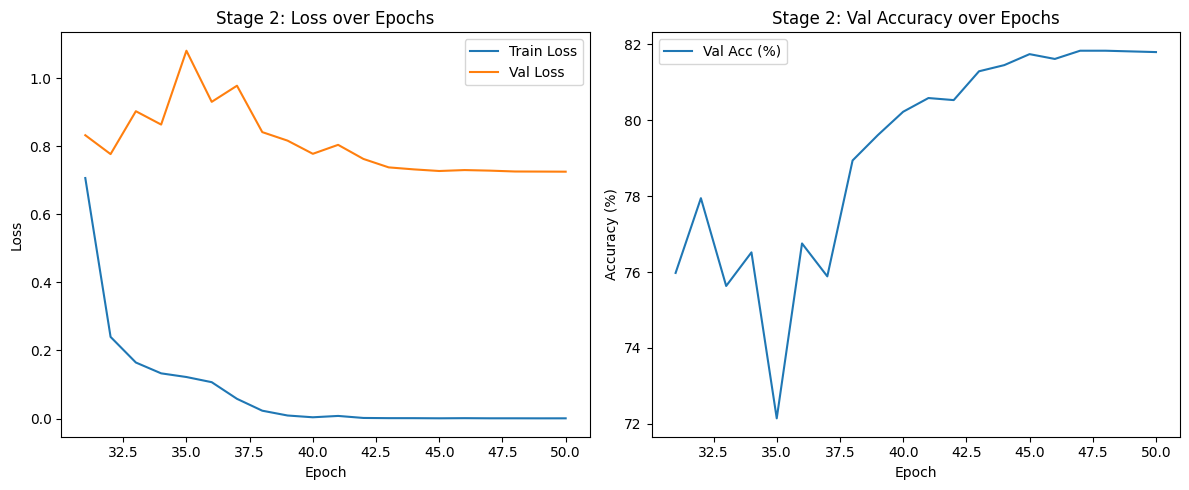

Final Eval [Val]: 100%|██████████| 173/173 [00:43<00:00,  4.02it/s]


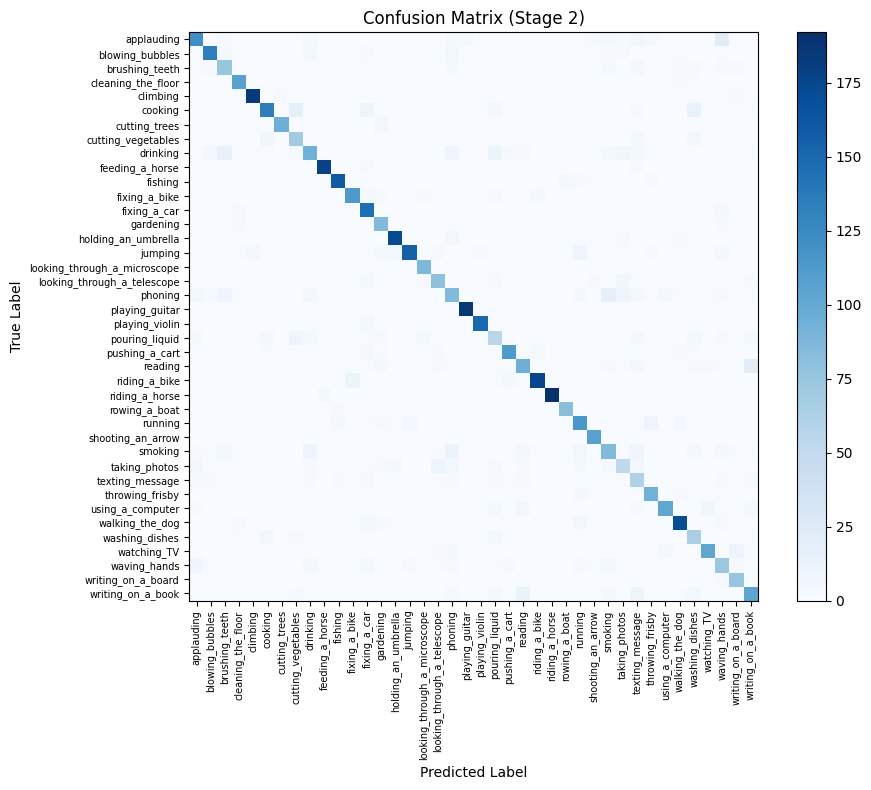

In [36]:

# ======================= 5. Loss & Accuracy ========================
epochs = np.arange(STAGE1_EPOCHS+1, STAGE1_EPOCHS + len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Train & Val Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 2: Loss over Epochs")
plt.legend()

# Val Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs) * 100, label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Stage 2: Val Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ======================= 6. Confusion Matrix and heatmap ========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Khi unfreeze toàn bộ mô hình, hiện tượng overfitting xảy ra trên tập huấn luyện. Do đó, tôi sẽ thử chỉ unfreeze một vài lớp cuối của khối Vision Transformer, như đề xuất trong bài báo, nhằm giúp mô hình học được đặc trưng phân bố hình ảnh liên quan đến hành động.

In [37]:
print(model)

ConVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-9): 10 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): GPSA(
        (qk): Linear(in_features=768, out_features=1536, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (pos_proj): Linear(in_features=3, out_features=16, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
     

In [38]:
# ======================= 1. Load model + head-only checkpoint (stage 1) ========================
model = timm.create_model("convit_base", pretrained=False)
in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

CHECKPOINT_PATH = "/kaggle/working/best_convit_stanford40.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
print("Loaded head-only checkpoint.")


# ======================= 2. Unfreeze some backbone blocks (stage 2) ========================
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

# Unfreeze 2 block Transformer (10, 11)
for idx in [10, 11]:
    for param in model.blocks[idx].parameters():
        param.requires_grad = True

# ======================= 3. Optimizer, Scheduler, Criterion ========================
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 3e-5
TOTAL_EPOCHS = 70
# STAGE1_EPOCHS = NUM_EPOCHS
# STAGE2_EPOCHS = TOTAL_EPOCHS - STAGE1_EPOCHS  # = 20
STAGE3_EPOCHS = TOTAL_EPOCHS - STAGE1_EPOCHS - STAGE2_EPOCHS # = 20

optimizer = SGD(model.head.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)   
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE2_EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss()

Loaded head-only checkpoint.


In [39]:
# ======================= 4. Stage 2 Training Loop + Save metrics ========================
train_losses = []
val_losses   = []
val_accs     = []

best_acc = 0.0
patience = 10
epochs_no_improve = 0

for epoch3 in range(1, STAGE3_EPOCHS + 1):
    epoch = STAGE1_EPOCHS + epoch3 + STAGE2_EPOCHS
    model.train()
    running_train_loss = 0.0
    total_train = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        running_train_loss += loss.item() * bs
        total_train += bs

    avg_train_loss = running_train_loss / total_train
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0.0
    total_val = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            bs = imgs.size(0)
            running_val_loss += loss.item() * bs
            total_val += bs

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_val_loss / total_val
    val_losses.append(avg_val_loss)

    val_acc = correct / total_val
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch}/{TOTAL_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"LR: {scheduler.get_last_lr()[0]:.6f}"
    )

    # Early stopping & lưu model tốt nhất
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_convit_stage3.pth")
        print(f"  → Saved new best model at epoch {epoch} (Val Acc={val_acc*100:.2f}%)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  → No improvement for {patience} epochs → Early stopping at epoch {epoch}")
            break

print(f"Finished Stage 3. Best Val Acc: {best_acc*100:.2f}%")

[Stage2] Epoch 51/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 51/70 | Train Loss: 0.2217 | Val Loss: 0.5231 | Val Acc: 84.80% | LR: 0.000994
  → Saved new best model at epoch 51 (Val Acc=84.80%)


[Stage2] Epoch 52/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 52/70 | Train Loss: 0.2163 | Val Loss: 0.5223 | Val Acc: 84.85% | LR: 0.000976
  → Saved new best model at epoch 52 (Val Acc=84.85%)


[Stage2] Epoch 53/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.95it/s]


Epoch 53/70 | Train Loss: 0.2124 | Val Loss: 0.5198 | Val Acc: 84.78% | LR: 0.000946


[Stage2] Epoch 54/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 54/70 | Train Loss: 0.2040 | Val Loss: 0.5186 | Val Acc: 84.98% | LR: 0.000905
  → Saved new best model at epoch 54 (Val Acc=84.98%)


[Stage2] Epoch 55/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 55/70 | Train Loss: 0.2027 | Val Loss: 0.5174 | Val Acc: 84.89% | LR: 0.000854


[Stage2] Epoch 56/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 56/70 | Train Loss: 0.1961 | Val Loss: 0.5165 | Val Acc: 84.96% | LR: 0.000794


[Stage2] Epoch 57/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 57/70 | Train Loss: 0.1913 | Val Loss: 0.5150 | Val Acc: 84.98% | LR: 0.000727


[Stage2] Epoch 58/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 58/70 | Train Loss: 0.1874 | Val Loss: 0.5144 | Val Acc: 85.00% | LR: 0.000655
  → Saved new best model at epoch 58 (Val Acc=85.00%)


[Stage2] Epoch 59/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 59/70 | Train Loss: 0.1847 | Val Loss: 0.5137 | Val Acc: 84.96% | LR: 0.000579


[Stage2] Epoch 60/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 60/70 | Train Loss: 0.1862 | Val Loss: 0.5132 | Val Acc: 85.03% | LR: 0.000501
  → Saved new best model at epoch 60 (Val Acc=85.03%)


[Stage2] Epoch 61/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 61/70 | Train Loss: 0.1803 | Val Loss: 0.5128 | Val Acc: 84.96% | LR: 0.000422


[Stage2] Epoch 62/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 62/70 | Train Loss: 0.1802 | Val Loss: 0.5122 | Val Acc: 85.00% | LR: 0.000346


[Stage2] Epoch 63/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 63/70 | Train Loss: 0.1756 | Val Loss: 0.5118 | Val Acc: 84.92% | LR: 0.000274


[Stage2] Epoch 64/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 64/70 | Train Loss: 0.1716 | Val Loss: 0.5118 | Val Acc: 84.94% | LR: 0.000207


[Stage2] Epoch 65/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 65/70 | Train Loss: 0.1781 | Val Loss: 0.5115 | Val Acc: 84.94% | LR: 0.000147


[Stage2] Epoch 66/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Epoch 66/70 | Train Loss: 0.1732 | Val Loss: 0.5114 | Val Acc: 84.92% | LR: 0.000096


[Stage2] Epoch 67/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 67/70 | Train Loss: 0.1712 | Val Loss: 0.5112 | Val Acc: 84.92% | LR: 0.000055


[Stage2] Epoch 68/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 68/70 | Train Loss: 0.1714 | Val Loss: 0.5112 | Val Acc: 84.92% | LR: 0.000025


[Stage2] Epoch 69/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.96it/s]


Epoch 69/70 | Train Loss: 0.1713 | Val Loss: 0.5111 | Val Acc: 84.92% | LR: 0.000007


[Stage2] Epoch 70/70 [ Val ]: 100%|██████████| 173/173 [00:43<00:00,  3.95it/s]

Epoch 70/70 | Train Loss: 0.1707 | Val Loss: 0.5111 | Val Acc: 84.92% | LR: 0.000001
  → No improvement for 10 epochs → Early stopping at epoch 70
Finished Stage 3. Best Val Acc: 85.03%


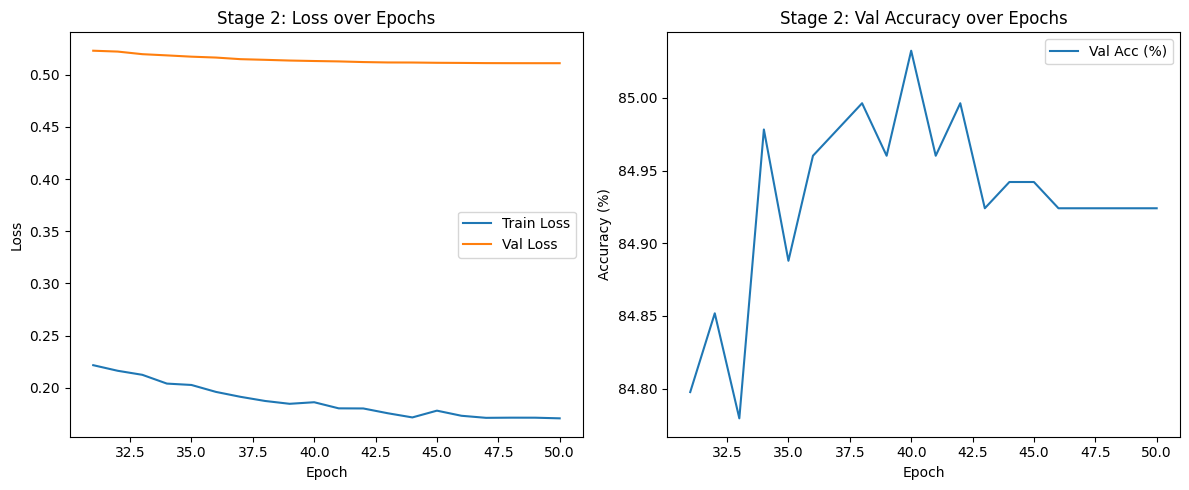

Final Eval [Val]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


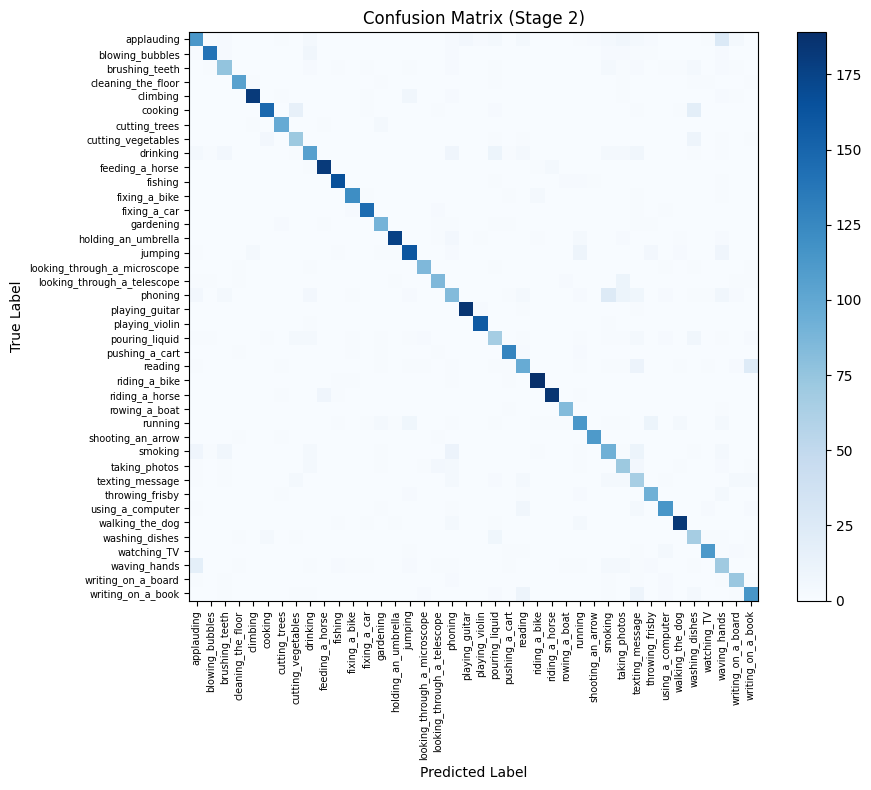

In [40]:
# ======================= 5. Loss & Accuracy ========================
epochs = np.arange(STAGE1_EPOCHS+1, STAGE1_EPOCHS + len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Train & Val Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 2: Loss over Epochs")
plt.legend()

# Val Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs) * 100, label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Stage 2: Val Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ======================= 6. Confusion Matrix and heatmap ========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import average_precision_score

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

=> mAP = 89.59%
